In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# -------------------------------
# CG (2015) Method Analysis
# -------------------------------
# Load CG Uncertainty data (adjust the file path as needed)
d = pd.read_csv("CG Uncertainty.csv", parse_dates=['date'])
d = d[(d['date'].dt.year >= 1996) & (d['date'].dt.year <= 2022)].copy()

# Calculate forecast error and forecast revision
d['For_error'] = d['Annualized Variance'] - d['avg_impl_variance30']
d['For_revision'] = d['avg_impl_variance30'] - d['Forecast,t-1 of X(t,t+h)']

print("=== CG Model: Regress For_error on For_revision (Equation 4) ===")
d_model1 = d[['For_revision', 'For_error']].replace([np.inf, -np.inf], np.nan).dropna()
X1 = sm.add_constant(d_model1['For_revision'])
y1 = d_model1['For_error']
model1 = sm.OLS(y1, X1).fit()
print(model1.summary())

# Extended model with uncertainty (Equation 6) if uncertainty column exists (assumed to be 'h=1')
if 'h=1' in d.columns:
    print("=== CG Model with Uncertainty Extension (Equation 6) ===")
    d['interaction'] = d['For_revision'] * d['h=1']
    d_model2 = d[['For_revision', 'h=1', 'interaction', 'For_error']].replace([np.inf, -np.inf], np.nan).dropna()
    X2 = sm.add_constant(d_model2[['For_revision', 'h=1', 'interaction']])
    y2 = d_model2['For_error']
    model2 = sm.OLS(y2, X2).fit()
    print(model2.summary())
else:
    print("Column 'h=1' not found in the CG data. Skipping uncertainty extension.")

# -------------------------------
# Stein (1989) Method Analysis
# -------------------------------
# Load Stein data (adjust the file path as needed)
df = pd.read_csv("Stein data thesis.csv", parse_dates=['date'])
df = df[(df['date'].dt.year >= 1996) & (df['date'].dt.year <= 2022)].copy()

# AR(1) regression on near implied variance (Equation 3)
df['lag_var30'] = df['avg_impl_variance30'].shift(1)
df_model = df[['avg_impl_variance30', 'lag_var30']].replace([np.inf, -np.inf], np.nan).dropna()

print("=== STEIN AR(1) Regression (Equation 3) ===")
X = sm.add_constant(df_model['lag_var30'])
y = df_model['avg_impl_variance30']
model_ar1 = sm.OLS(y, X).fit()
print(model_ar1.summary())

# Spread analysis: regression of (it^d - sigma) on (it^n - sigma) (Equation 1)
mean_variance = df['historical variance'].mean(skipna=True)
df['spread_short'] = df['avg_impl_variance30'] - mean_variance
df['spread_long'] = df['avg_impl_variance60'] - mean_variance
df_model2 = df[['spread_short', 'spread_long']].replace([np.inf, -np.inf], np.nan).dropna()

print("=== STEIN Spread Analysis (Equation 1): spread_long ~ spread_short ===")
X2 = sm.add_constant(df_model2['spread_short'])
y2 = df_model2['spread_long']
model_spread = sm.OLS(y2, X2).fit()
print(model_spread.summary())


=== CG Model: Regress For_error on For_revision (Equation 4) ===
                            OLS Regression Results                            
Dep. Variable:              For_error   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     181.4
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           7.92e-41
Time:                        22:30:37   Log-Likelihood:                 9803.9
No. Observations:                6775   AIC:                        -1.960e+04
Df Residuals:                    6773   BIC:                        -1.959e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

/var/folders/wn/lk75hc7s65b7ljzsdgw30f7c0000gn/T/ipykernel_19857/1698059152.py:8: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  options = pd.read_csv('/Users/jorambakker/Downloads/Optionprices(1).csv')
/var/folders/wn/lk75hc7s65b7ljzsdgw30f7c0000gn/T/ipykernel_19857/1698059152.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = combined_df.groupby(['date', 'cp_flag']).apply(filter_options).reset_index(drop=True)


2009-03-23 - Open short position at strike=825.0, S=822.92, Cost/Revenue=65.75, Balance=65.75$
  Option Prices: Call Bid=31.0, Call Offer=33.3, Put Bid=32.2, Put Offer=35.0
2009-04-17 - Close position with P/L: 21.15$, Return: 32.17%, Updated Balance: 21.15$
  Details: Position=short, Strike=825.0$, Close=869.6$, Payoff=-44.6, Cost=65.75$, Profit=21.15$

2009-04-20 - Open short position at strike=830.0, S=832.39, Cost/Revenue=63.15, Balance=84.3$
  Option Prices: Call Bid=31.7, Call Offer=33.5, Put Bid=29.9, Put Offer=31.2
2009-05-15 - Close position with P/L: 10.27$, Return: 16.26%, Updated Balance: 31.42$
  Details: Position=short, Strike=830.0$, Close=882.88$, Payoff=-52.88, Cost=63.15$, Profit=10.27$

2009-05-18 - Open short position at strike=910.0, S=909.71, Cost/Revenue=57.55, Balance=88.97$
  Option Prices: Call Bid=27.0, Call Offer=28.2, Put Bid=29.4, Put Offer=30.5
2009-06-19 - Close position with P/L: 46.32$, Return: 80.49%, Updated Balance: 77.74$
  Details: Position=short,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


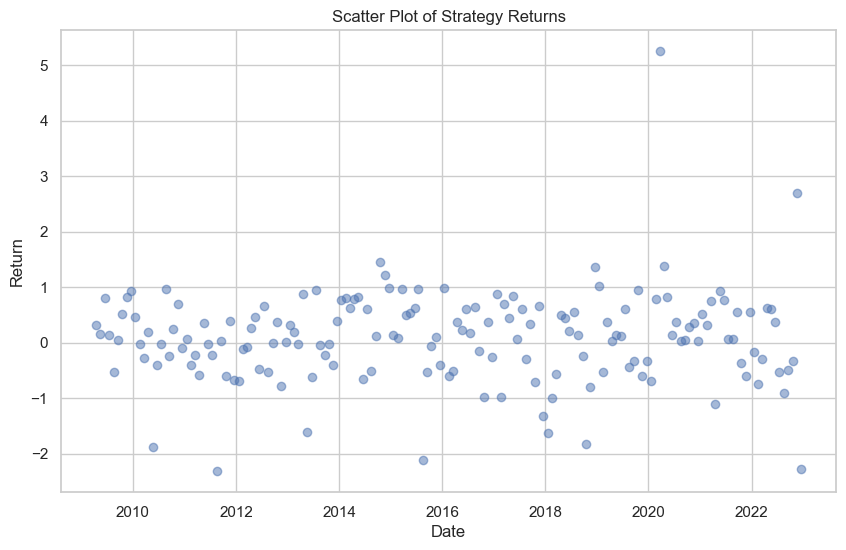

/var/folders/wn/lk75hc7s65b7ljzsdgw30f7c0000gn/T/ipykernel_19857/1698059152.py:311: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rf_rate['Date'] = pd.to_datetime(rf_rate['Date'])


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.843
Date:                Mon, 17 Mar 2025   Prob (F-statistic):             0.0517
Time:                        00:15:01   Log-Likelihood:                -201.02
No. Observations:                 164   AIC:                             406.0
Df Residuals:                     162   BIC:                             412.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1155      0.066      1.750      0.0

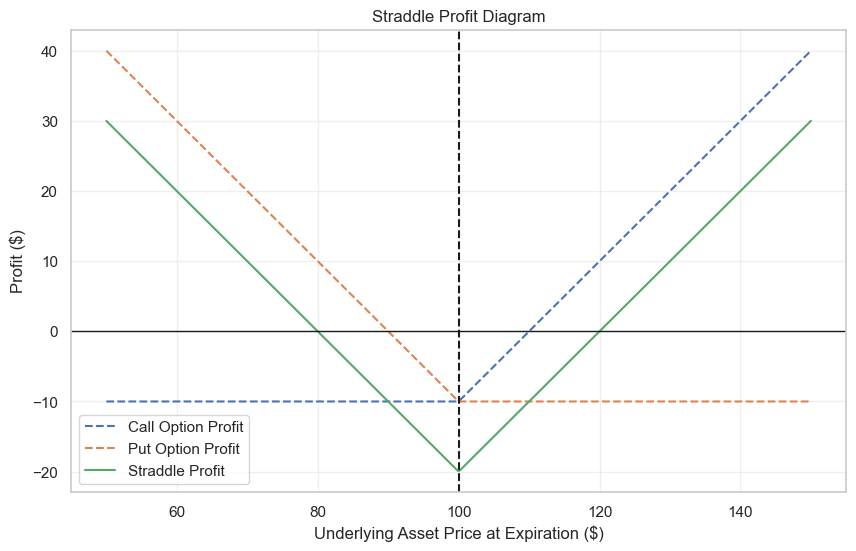

In [17]:
# %% [1] Imports
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# %% [2] Load and preprocess data
options = pd.read_csv('/Users/jorambakker/Downloads/Optionprices(1).csv')
sp500_df = pd.read_csv('/Users/jorambakker/Downloads/SP500.csv')

# Convert the date columns to datetime
options['date'] = pd.to_datetime(options['date'])
options['exdate'] = pd.to_datetime(options['exdate'])
sp500_df['date'] = pd.to_datetime(sp500_df['date'])

# Display an initial slice of the options data
options.head(54)

# Filter out rows where 'expiry_indicator' is not NaN
options = options[options['expiry_indicator'].isna()]

# %% [3] Merge options with S&P 500 data; compute moneyness
combined_df = pd.merge(options, sp500_df, on='date', how='left')
combined_df['strike_price'] = combined_df['strike_price'] / 1000
combined_df['mnes'] = combined_df.apply(lambda row: row['close'] / row['strike_price'], axis=1)

# %% [4] Filtering function for nearest maturity and moneyness
def filter_options(group):
    # Filter out entries where the day of expiry is <= 13
    filtered = group[group['exdate'].dt.day > 13]
    if filtered.empty:
        return None
    # Find the row with the nearest maturity
    nearest_maturity = filtered.loc[filtered['exdate'].idxmin()]
    # Filter to the nearest maturity
    filtered = filtered[filtered['exdate'] == nearest_maturity['exdate']]
    # Find the option with moneyness closest to 1
    filtered['moneyness_diff'] = abs(filtered['mnes'] - 1)
    return filtered.loc[filtered['moneyness_diff'].idxmin()]

# Group by 'date' and 'cp_flag' and apply the filter
result = combined_df.groupby(['date', 'cp_flag']).apply(filter_options).reset_index(drop=True)
result.drop(columns=['moneyness_diff'], inplace=True)
result['maturity_days'] = (result['exdate'] - result['date']).dt.days

# %% [5] Pivot data for calls and puts
df = result.copy()
pivot_df = df.pivot_table(
    index='date',
    columns='cp_flag',
    values=['best_bid', 'best_offer'],
    aggfunc='first'
)
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
pivot_df.reset_index(inplace=True)

# Keep other relevant columns outside the pivot
non_pivot_data = df[['date', 'exdate', 'strike_price', 'open', 'close', 'maturity_days']].drop_duplicates(subset=['date'])

# Merge pivoted and non-pivoted data
final_df = pd.merge(non_pivot_data, pivot_df, on='date', how='left')

# Reorder columns
new_order = [
    'date', 'exdate', 'strike_price',
    'best_bid_C', 'best_offer_C',
    'best_bid_P', 'best_offer_P',
    'open', 'close', 'maturity_days'
]
final_df = final_df[new_order]

# Save intermediate result
final_df.to_csv('df.csv', index=False)

# %% [6] Identify 3rd Fridays, 3rd Thursdays, and the day after
df = final_df.copy()
df['date'] = pd.to_datetime(df['date'])

def is_third_weekday(s, weekday=4):
    # Checks if 's' is the third occurrence of 'weekday' in its month (weekday=4 -> Friday).
    return (s.weekday() == weekday) and (15 <= s.day <= 21)

df['is_third_friday'] = df['date'].apply(lambda x: is_third_weekday(x, weekday=4))
df['is_third_thursday'] = df['date'].apply(lambda x: is_third_weekday(x, weekday=3))
df['month'] = df['date'].dt.to_period('M')

# Check if there is a third Friday in each month
third_friday_exists = df.groupby('month')['is_third_friday'].transform('max')

# Flags for day after
df['day_after_third_friday'] = df['is_third_friday'].shift(1)
df['day_after_third_thursday'] = df['is_third_thursday'].shift(1)

# Conditions to include date
df['include_date'] = (
    df['is_third_friday'] |
    (df['is_third_thursday'] & ~third_friday_exists) |
    (df['day_after_third_friday'] & third_friday_exists) |
    (df['day_after_third_thursday'] & ~third_friday_exists)
)

filtered_df = df[df['include_date']]

# %% [7] Merge with CG data (For_error, For_revision, etc.)
cg = pd.read_csv('/Users/jorambakker/my_dataframe.csv')
cg['date'] = pd.to_datetime(cg['date'])

backtest = pd.merge(filtered_df, cg[['date', 'For_error', 'For_revision']], on='date', how='right')

# %% [8] Calculate rolling beta on For_revision vs. For_error
backtest['beta'] = None

def calculate_beta(data):
    """Helper function to compute beta using OLS of For_error on For_revision."""
    data = data.dropna(subset=['For_revision', 'For_error'])
    if len(data) > 1:
        X = sm.add_constant(data['For_revision'])
        y = data['For_error']
        model = sm.OLS(y, X).fit()
        return model.params['For_revision']
    return None

betas = []
for i in range(len(backtest)):
    subset = backtest.iloc[:i+1]
    betas.append(calculate_beta(subset))

backtest['beta'] = betas

# Save intermediate results
backtest.to_csv('testtttt.csv', index=False)

# %% [9] Merge beta results back into filtered_df
strategy = pd.merge(filtered_df, backtest[['date', 'For_error', 'For_revision', 'beta']],
                    on='date', how='left')
strategy.to_csv('strategy.csv', index=False)

# %% [10] Backtest class
class BacktestStraddle:
    def __init__(self) -> None:
        self.df = pd.DataFrame()
        self.results_df = pd.DataFrame()

    def get_results_df(self):
        """Return the results DataFrame containing the trade results."""
        return self.results_df

    def load_data(self, path):
        """Load data from CSV and filter to 2009 onwards."""
        self.df = pd.read_csv(path)
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df = self.df[self.df['date'].dt.year >= 2009]
        self.df['year_month'] = self.df['date'].dt.to_period('M')
        self.df.set_index('date', inplace=True)

    def populate_signals(self):
        """
        Compute trading signals using a rolling window of past For_revision values,
        avoiding look‑ahead bias. A signal is only generated if the absolute For_revision
        exceeds a threshold based on the rolling std. If beta >= 0, use normal logic;
        if beta < 0, invert the signal.
        """
        window_size = 50
        min_periods = 5
        threshold_multiplier = 0  # Adjust multiplier as needed

        # Rolling std on For_revision, shifted by 1 day to avoid look-ahead
        self.df['rolling_std'] = (
            self.df['For_revision']
            .shift(1)
            .rolling(window=window_size, min_periods=min_periods)
            .std()
        )

        # Observation rank within each year_month
        self.df['observation_rank'] = self.df.groupby('year_month').cumcount() + 1

        def determine_position(for_revision, beta, rolling_std):
            if pd.isna(rolling_std):
                return None
            threshold = threshold_multiplier * rolling_std
            if abs(for_revision) < threshold:
                return None
            if beta < 0:
                return 'short' if for_revision > 0 else 'long'
            return 'long' if for_revision > 0 else 'short'

        # Generate signals only on the 2nd observation of each month
        mask = self.df['observation_rank'] == 2
        self.df.loc[mask, 'position'] = self.df[mask].apply(
            lambda row: determine_position(
                row['For_revision'],
                row['beta'],
                row['rolling_std']
            ),
            axis=1
        )

    @staticmethod
    def calculate_option_payoff(close_price, strike_price, position):
        """Calculate payoff of a straddle at expiration."""
        call_payoff = max(0, close_price - strike_price)
        put_payoff = max(0, strike_price - close_price)

        if position == 'long':
            return call_payoff + put_payoff
        elif position == 'short':
            return -(call_payoff + put_payoff)
        return 0

    def run_backtest(self):
        balance = 0
        position = None
        strike_price = None
        trade_cost = 0
        open_date = None

        for index, row in self.df.iterrows():
            # Close position if we have one and the current rank is 1
            if position and (self.df.loc[index, 'observation_rank'] == 1):
                days_held = (index - open_date).days
                payoff = self.calculate_option_payoff(row['close'], strike_price, position)

                if position == 'long':
                    profit = payoff - trade_cost
                    return_percentage = (profit / trade_cost) * 100 if trade_cost != 0 else 0
                else:
                    profit = payoff + trade_cost
                    return_percentage = (-payoff / trade_cost - 1) * -100 if payoff != 0 else 0

                balance += payoff

                print(f"{index.date()} - Close position with P/L: {round(profit, 2)}$, "
                      f"Return: {round(return_percentage, 2)}%, "
                      f"Updated Balance: {round(balance, 2)}$")
                print(f"  Details: Position={position}, Strike={round(strike_price,2)}$, "
                      f"Close={round(row['close'],2)}$, Payoff={round(payoff,2)}, "
                      f"Cost={round(trade_cost,2)}$, Profit={round(profit,2)}$\n")

                # Log results
                new_row = pd.DataFrame({
                    'Date': [index.date()],
                    'For_revision': [row['For_revision']],
                    'beta': [row['beta']],
                    'Position': [position],
                    'Strike': [strike_price],
                    'Close Price': [row['close']],
                    'Payoff': [payoff],
                    'Initial costs/revenue': [-trade_cost],
                    'Profit_Loss': [profit],
                    'Return_Percentage': [return_percentage / 100],
                    'Balance': [round(balance, 2)],
                    'Days Held': [days_held],
                    'Days till maturity': [row['maturity_days']]
                })
                self.results_df = pd.concat([self.results_df, new_row], ignore_index=True)
                position = None

            # Open position if signaled and rank is 2
            elif row['position'] and (self.df.loc[index, 'observation_rank'] == 2):
                open_date = index
                position = row['position']
                strike_price = row['strike_price']
                trade_cost = (
                    (row['best_offer_C'] + row['best_bid_C']) / 2 +
                    (row['best_offer_P'] + row['best_bid_P']) / 2
                )

                # Adjust balance
                if position == 'long':
                    balance -= trade_cost
                else:
                    balance += trade_cost

                print(f"{index.date()} - Open {position} position at strike={strike_price}, "
                      f"S={round(row['close'],2)}, Cost/Revenue={round(trade_cost, 2)}, "
                      f"Balance={round(balance, 2)}$")
                print("  Option Prices: "
                      f"Call Bid={row['best_bid_C']}, Call Offer={row['best_offer_C']}, "
                      f"Put Bid={row['best_bid_P']}, Put Offer={row['best_offer_P']}")

        print(f"Final balance: {round(balance, 2)}$")

# %% [11] Run the backtest
backtester = BacktestStraddle()
backtester.load_data('strategy.csv')
backtester.populate_signals()
backtester.run_backtest()

results_df = backtester.get_results_df()

# %% [12] Analyze results
results_df["SP500 return"] = results_df["Close Price"].pct_change()
results_df['Return_log'] = np.log(1 + results_df['Return_Percentage'])
results_df['ReturnSP500_log'] = np.log(1 + results_df['SP500 return'])

# Simple scatter plot of raw percentage returns
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Date'], results_df['Return_Percentage'], alpha=0.5)
plt.title('Scatter Plot of Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.show()

# Save final results to CSV
results_df.to_csv('results_strategy.csv', index=False)

# %% [13] Risk-free rates and regression
rf_rate = pd.read_csv('/Users/jorambakker/Downloads/bill-rates-2002-2023.csv')
rf_rate['Date'] = pd.to_datetime(rf_rate['Date'])
results_df['Date'] = pd.to_datetime(results_df['Date'])


data1 = pd.merge(results_df, rf_rate[['Date', '4 WEEKS COUPON EQUIVALENT']], 
                 on='Date', how='left')
data1["rf_rate"] = data1["4 WEEKS COUPON EQUIVALENT"] / 100 / 12

data1 = data1.dropna(subset=['SP500 return', 'Return_Percentage', 'rf_rate'])

X = data1['SP500 return'] - data1["rf_rate"]
Y = data1['Return_Percentage'] - data1["rf_rate"]

# OLS regression
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

# %% [14] Simple straddle payoff plot example
K = 100  # Strike price
C = 10   # Premium for the call option
P = 10   # Premium for the put option

S = np.linspace(50, 150, 400)
payoff_call = np.maximum(0, S - K) - C
payoff_put = np.maximum(0, K - S) - P
payoff_straddle = payoff_call + payoff_put

plt.figure(figsize=(10, 6))
plt.plot(S, payoff_call, label='Call Option Profit', linestyle='--')
plt.plot(S, payoff_put, label='Put Option Profit', linestyle='--')
plt.plot(S, payoff_straddle, label='Straddle Profit')
plt.axhline(0, color='k', linewidth=1)
plt.axvline(K, color='k', linestyle='--')
plt.title('Straddle Profit Diagram')
plt.xlabel('Underlying Asset Price at Expiration ($)')
plt.ylabel('Profit ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('straddle_payoff.png')
plt.show()
